In [1]:
import numpy as np
import pandas as pd
from pydub import AudioSegment,silence
from pydub.generators import WhiteNoise
from pydub.playback import play
import subprocess
import random
import sys
import io
import csv
import os
import glob
import IPython

import IPython.display as ip
from IPython.display import HTML
from td_utils import *
from mpl_toolkits import mplot3d
import math
%matplotlib inline

C:\Users\Prathyusha\AppData\Local\Programs\Python\Python36\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras

import tensorflow as tf

In [4]:

def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
        retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])

    return ((resig, newsr))

In [5]:
 def load_raw_audio():
    newacts = []
    activates=[]
    backgrounds = []
    negatives = []
    for filename in os.listdir("../train/fin_train"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("../train/fin_train/"+filename)
            reaud=AudioSegment.set_frame_rate(activate,44100)
            newacts.append(reaud)
    for filename in os.listdir("./raw_data/activates"):
        if filename.endswith("wav"):
            activatess = AudioSegment.from_wav("./raw_data/activates/"+filename)
            reaudact=AudioSegment.set_frame_rate(activatess,44100)
            activates.append(reaudact)
    for filename in os.listdir("./raw_data/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("./raw_data/backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("./test_nww"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("./test_nww/"+filename)
            reaudnegative=AudioSegment.set_frame_rate(negative,44100)
            negatives.append(reaudnegative)
    return newacts,activates, negatives, backgrounds
    


In [6]:
IPython.display.Audio("audio_examples/example_train.wav")

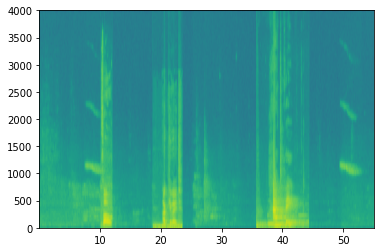

In [7]:
x = graph_spectrogram("audio_examples/example_train.wav")

In [8]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [9]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [10]:
Ty = 1375 # The number of time steps in the output of our model

In [11]:
# Load audio segments using pydub 
newacts, activates,negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activates_1[23] len: " + str(len(activates[2])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
#print("activate_1[23] len: " + str(len(activates[1])))


background len: 10000
activates_1[23] len: 563


In [16]:
tf.compat.v1.disable_v2_behavior()
model = load_model('./models/tr_model.h5')

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
in_shape=model.layers[0].get_input_shape_at(0)[1:]
print(in_shape)

(5511, 101)


In [18]:
def newmodel(input_shape):
    new_input = Input(shape=in_shape)
    x = new_input
    for layer in model.layers[:-1]:
        x = layer(x)


    x = Dense(3, activation='softmax')(x)

    new_model = Model(inputs=new_input, outputs=x)
    return new_model

In [19]:
new_model = newmodel(input_shape = (Tx, n_freq))

In [20]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
input_3 (InputLayer)         multiple                  0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1375, 256)         388096    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1375, 256)         1024      
_________________________________________________________________
activation_3 (Activation)    (None, 1375, 256)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1375, 256)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1375, 128)         147840

In [23]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
new_model.fit(X, Y, batch_size = 10, epochs=500)

Train on 440 samples
Epoch 1/500
440/440 [==============================] - 237s 539ms/sample - loss: 0.0948 - acc: 0.9694
Epoch 2/500
440/440 [==============================] - 218s 494ms/sample - loss: 0.0774 - acc: 0.9733
Epoch 3/500
440/440 [==============================] - 233s 529ms/sample - loss: 0.0721 - acc: 0.9750
Epoch 4/500
440/440 [==============================] - 249s 567ms/sample - loss: 0.0745 - acc: 0.9753
Epoch 5/500
440/440 [==============================] - 248s 564ms/sample - loss: 0.0693 - acc: 0.9766
Epoch 6/500
440/440 [==============================] - 244s 555ms/sample - loss: 0.0707 - acc: 0.9760
Epoch 7/500
440/440 [==============================] - 250s 569ms/sample - loss: 0.0658 - acc: 0.9780
Epoch 8/500
440/440 [==============================] - 242s 549ms/sample - loss: 0.0669 - acc: 0.9774
Epoch 9/500
440/440 [==============================] - 240s 545ms/sample - loss: 0.0665 - acc: 0.9773
Epoch 10/500
440/440 [==============================] - 234s 

In [116]:
new_model.save('./models/3_mod_classmodel_good.h5')

In [21]:
tf.compat.v1.disable_v2_behavior()
new_model.load_weights('./models/3classmodel.h5')

In [22]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = new_model.predict(x)

#     plt.subplot(2, 1, 2)
#     plt.plot(predictions[0,:,0])
#     plt.ylabel('probability')
#     plt.show()
    return predictions

## 3 Class-Test and Short Time Energy

In [24]:
from termcolor import colored
import librosa
import librosa.display
import scipy.io.wavfile as wav


 sound 1_act2 noise PN SNR0 BW 0-4000 time 4 pos 300.wav length is 631


C:\Users\Prathyusha\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


1.0
2
Possibility of attack


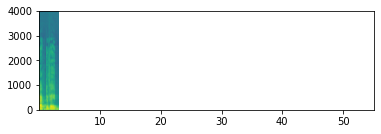

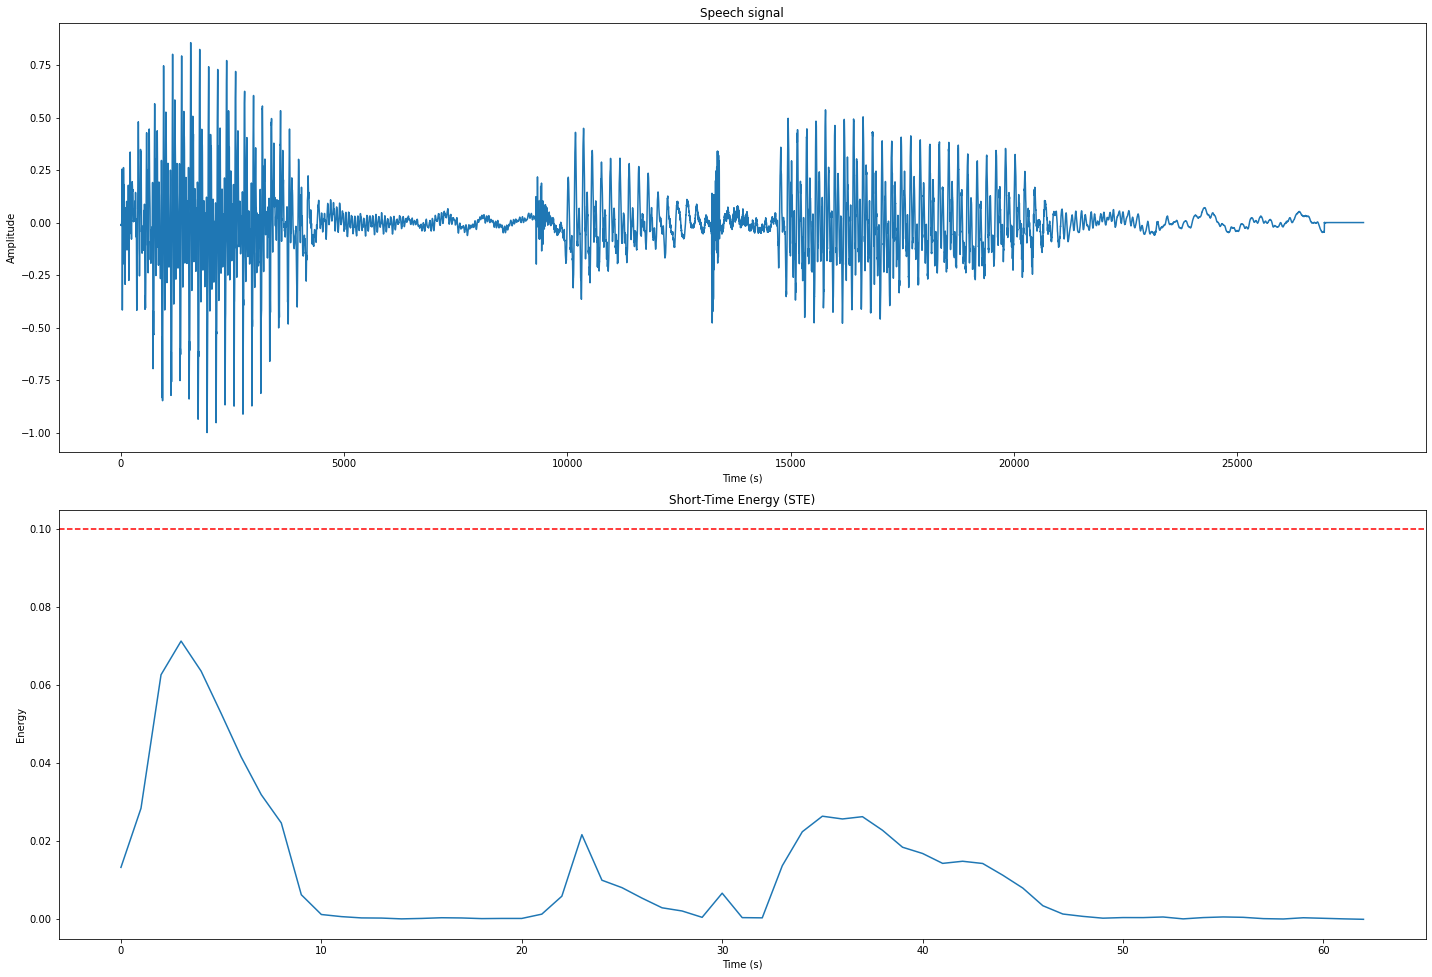

IndexError: list index out of range

In [157]:
soundpath="./raw_data/test1"
s_index=0

filenum=os.listdir(soundpath)
while s_index<=len(filenum):
    filenames=glob.glob(os.path.join(soundpath, '*.wav'))
    sound = AudioSegment.from_wav(filenames[s_index])
    end=len(sound)
    sound=sound.set_frame_rate(44100)
    print(" sound {} length is {}".format(os.path.basename(filenames[s_index]),end))
    nonsil=silence.detect_nonsilent(sound,min_silence_len=1,silence_thresh=-25,seek_step=1)
    start=nonsil[0]
    nonsilstart=start[0]
    #print(nonsilstart)
    total=10001-end
    trailsil = AudioSegment.silent(duration=total)
    final=sound+trailsil
    finale  = final.export("finale.wav",format="wav")

    #chime_on_activate(sound, prediction, 0.5)
    #IPython.display.Audio("./chime_output.wav")
    predictions1 = detect_triggerword(finale)
    print(np.amax(predictions1))
    predicted_classes = np.argmax(predictions1, axis=-1)
    class_values_list = predicted_classes.tolist()[0]
    print(max(class_values_list))
    
    if (max(class_values_list)>1):
        print(colored("Possibility of attack","red",attrs=["bold"]))
        fs,s = wav.read(filenames[s_index])
        s=s/max(abs(s))
        win = 0.02  # Window size (in seconds)
        hop = 0.01  # Hop size (in seconds)
        threshold = 0.1  # Energy threshold for detecting changes

        # Calculate Short-Time Energy (STE)
        winlen = math.ceil(win * fs)
        hlen = math.ceil(hop * fs)
        slices=math.floor(len(s)/hlen)
        a=np.reshape(s[:hlen *slices], (slices,hlen))
        ste = np.sum( np.transpose(a)** 2, axis=0) / winlen

        # change_points = np.where(np.diff(ste > threshold) != 0)[0]
        # change_points = change_points * hop
        plt.figure(figsize=(20,20))
        plt.subplot(3, 1, 1)
        plt.plot(s)
        plt.title('Speech signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 2)
        plt.plot(ste)
        plt.title('Short-Time Energy (STE)')
        plt.xlabel('Time (s)')
        plt.ylabel('Energy')
        plt.axhline(y=threshold, color='r', linestyle='--')
        plt.tight_layout()
        plt.show()
    elif (max(class_values_list)==1):
        print("It's a wake word")
    elif(max(class_values_list)==0):
        print("non wake word")

    
    s_index+=1



## Confusion Matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Replace this with your model's prediction function
end=800
def load_data(path):
    data = []
    for folder in ["non_wake_words", "wake_words", "wake_words_noise"]:
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                data.append((folder, file_path))
    return data

# Label the data
def label_data(data):
    labels = []
    for folder, _ in data:
        if folder == "non_wake_words":
            labels.append(0)
        elif folder == "wake_words":
            labels.append(1)
        elif folder == "wake_words_noise":
            labels.append(2)
    return labels

# Load your data
data_path = "./raw_data/test"
test_data = load_data(data_path)
y_test = label_data(test_data)



#         print(np.amax(predictions1))
    
#         predicted_classes = np.argmax(predictions1, axis=-1)
#         class_values_list = predicted_classes.tolist()[0]

y_pred = []
pos=["no","no","no","no","100","100 & 110","300","148","100 & 200","250"]
for _, file_path in test_data:
    print(file_path)
    predicts = detect_triggerword(file_path)
    pred_classes=np.argmax(predicts,axis=-1)
    pred_label = np.argmax(predicts,axis=-1)[0]  # Extract scalar value from NumPy array
    y_pred.append(max(pred_label))
    print(y_pred)
    class_values_list = pred_classes.tolist()[0]
    if (max(class_values_list)>1):
        file_name, file_extension = os.path.splitext(file_path)
        if file_extension == '.wav':
            wa = AudioSegment.from_wav(file_path)
            wa_1=wa[:end]
            wa_2=wa_1.export("./raw_data/test/cutsound.wav",format="wav")
            print(pos,colored("Possibility of attack","red",attrs=["bold"]))
            fs,s = wav.read("./raw_data/test/cutsound.wav")
            s=s/max(abs(s))
            print(fs,s)
            win = 0.02  # Window size (in seconds)
            hop = 0.01  # Hop size (in seconds)
            threshold = 0.08  # Energy threshold for detecting changes

            # Calculate Short-Time Energy (STE)
            winlen = math.ceil(win * fs)
            hlen = math.ceil(hop * fs)
            slices=math.floor(len(s)/hlen)
            a=np.reshape(s[:hlen *slices], (slices,hlen))
            ste = np.sum( np.transpose(a)** 2, axis=0) / winlen

            # change_points = np.where(np.diff(ste > threshold) != 0)[0]
            # change_points = change_points * hop
            plt.figure(figsize=(20,20))
            plt.subplot(3, 1, 1)
            plt.plot(s)
            plt.title('Speech signal')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')

            plt.subplot(3, 1, 2)
            plt.plot(ste)
            plt.title('Short-Time Energy (STE)')
            plt.xlabel('Time (s)')
            plt.ylabel('Energy')
            plt.axhline(y=threshold, color='r', linestyle='--')
            plt.tight_layout()
            plt.show()
results = {'True Label': y_test,
           'Predicted Label': y_pred,
           'File Name': [os.path.basename(file_path) for _, file_path in test_data],
           'Noise Presence': pos}
df = pd.DataFrame(results)
pd.set_option('display.width', 1000)

print(df.to_string(index=False))
    
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal',colorbar=False,ax=ax)
plt.show()
            
        
            


./raw_data/test\non_wake_words\1.wav
[0]
./raw_data/test\non_wake_words\4.wav


C:\Users\Prathyusha\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[0, 0]
./raw_data/test\wake_words\22.wav
[0, 0, 1]
./raw_data/test\wake_words\activate.wav
[0, 0, 1, 1]
./raw_data/test\wake_words_noise\0 noise BN SNR0 BW 0-1000 window length 128 pos 100.wav
[0, 0, 1, 1, 2]
['no', 'no', 'no', 'no', '100', '100 & 110', '300', '148', '100 & 200', '250'] Possibility of attack
44100 [ 7.92675677e-05  1.98168919e-04  3.96337838e-04 ... -3.96337838e-05
  1.58535135e-04  1.18901352e-04]


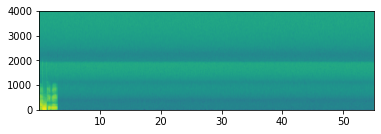

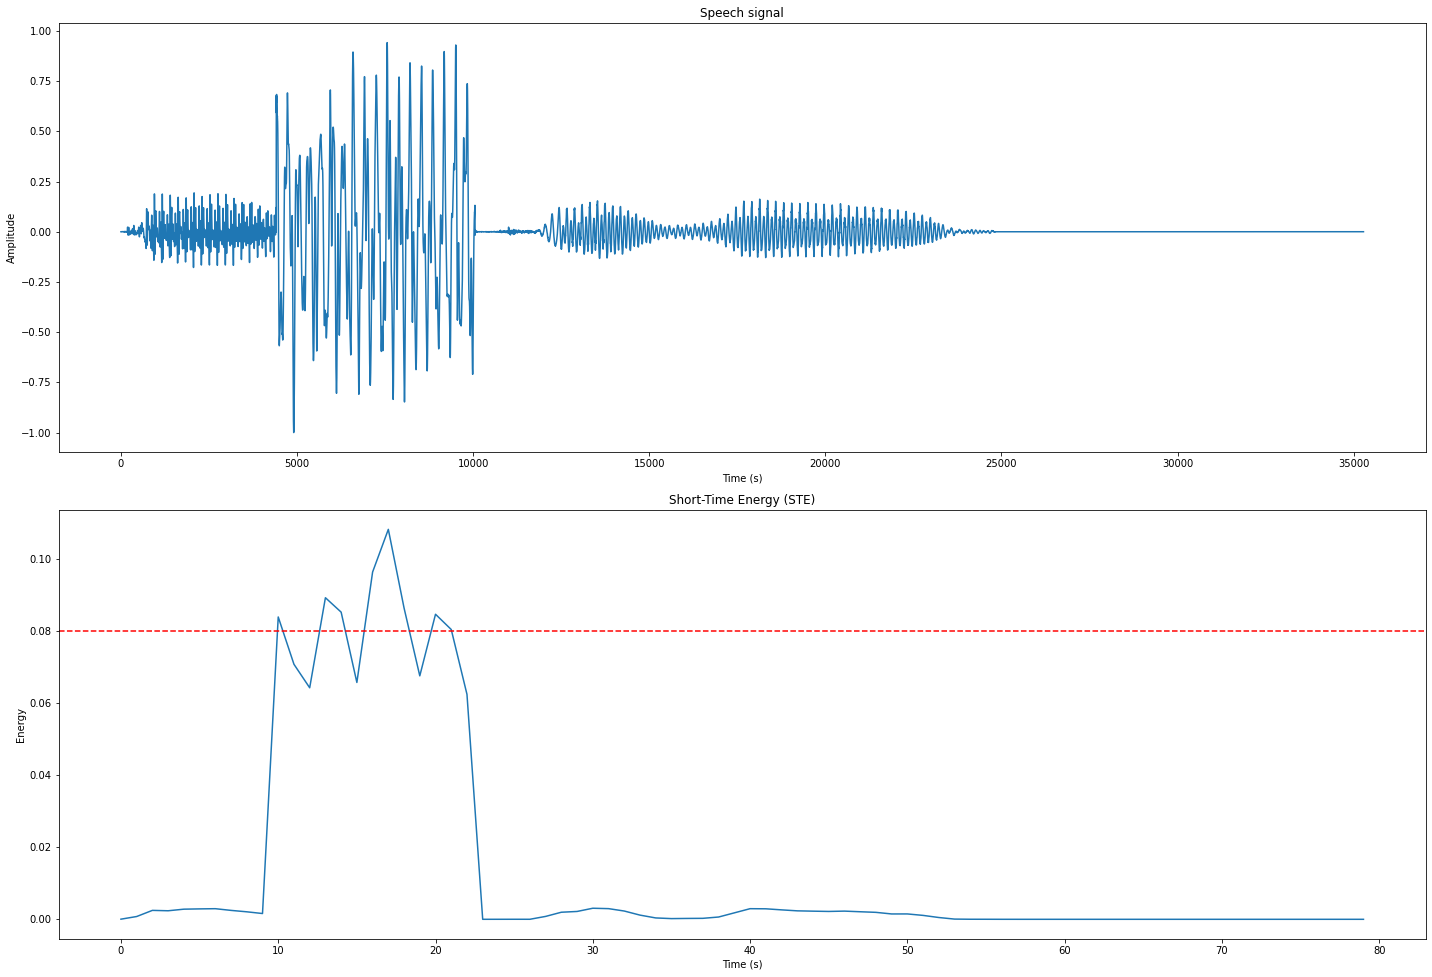

./raw_data/test\wake_words_noise\1 noise PN SNR0 BW 0-1000 time 128 pos 100 and 110.wav
[0, 0, 1, 1, 2, 2]
['no', 'no', 'no', 'no', '100', '100 & 110', '300', '148', '100 & 200', '250'] Possibility of attack
44100 [ 3.40657469e-05  2.38460228e-04  2.72525975e-04 ... -3.40657469e-05
  1.02197241e-04  1.36262988e-04]


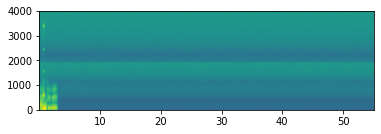

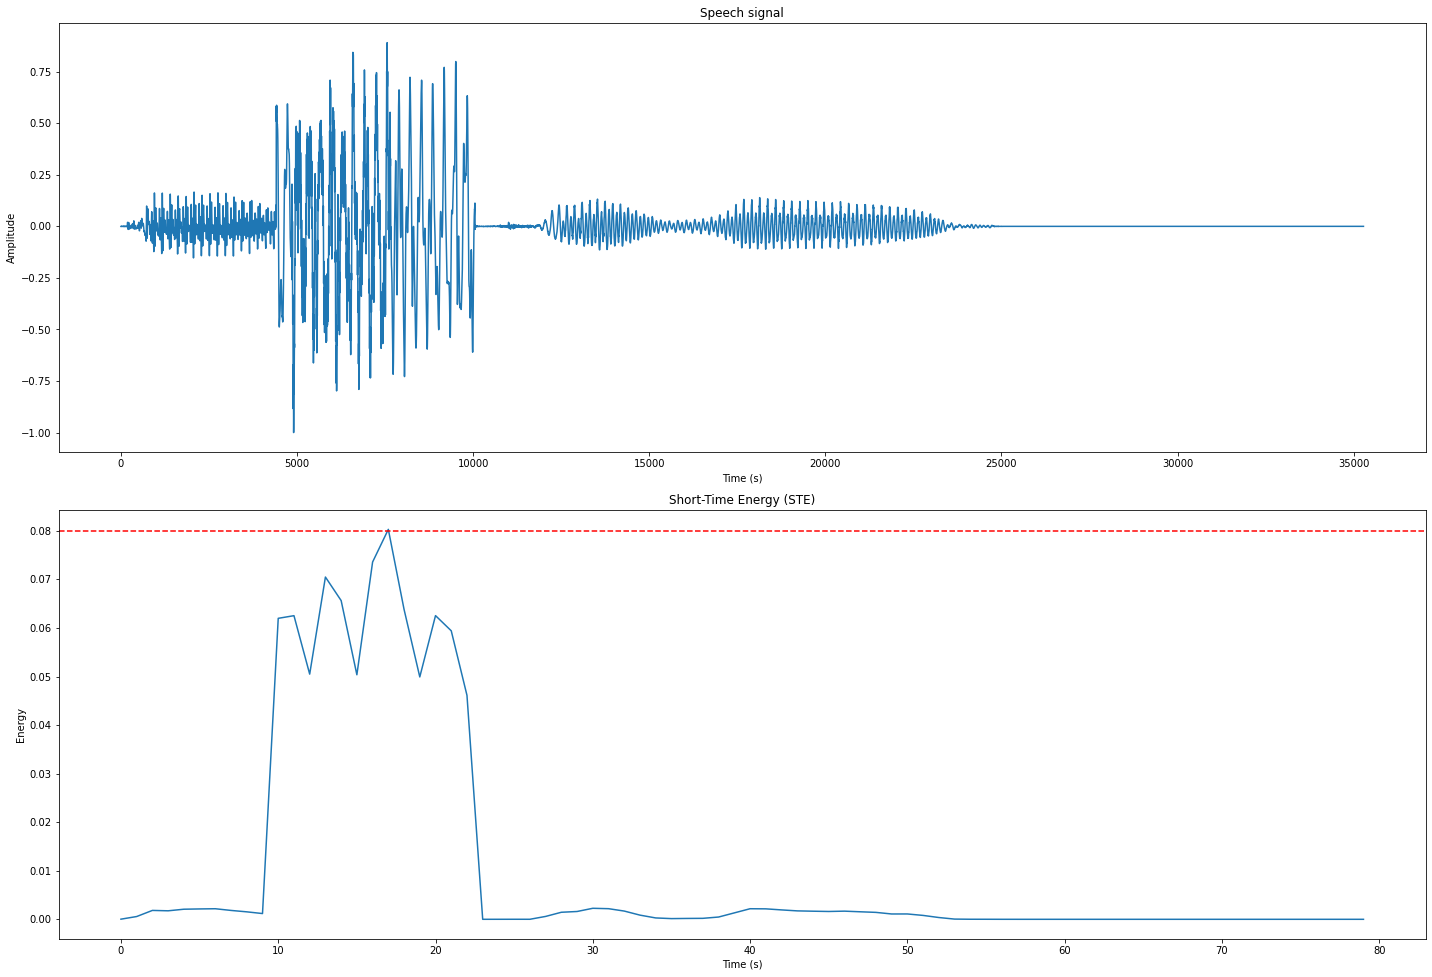

./raw_data/test\wake_words_noise\1_act2 noise PN SNR0 BW 0-4000 time 2 pos 300.wav
[0, 0, 1, 1, 2, 2, 2]
['no', 'no', 'no', 'no', '100', '100 & 110', '300', '148', '100 & 200', '250'] Possibility of attack
44100 [-1.33283969e-02 -1.14309515e-02 -9.34838949e-03 ... -4.62791559e-05
  0.00000000e+00  4.62791559e-05]


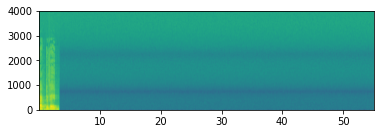

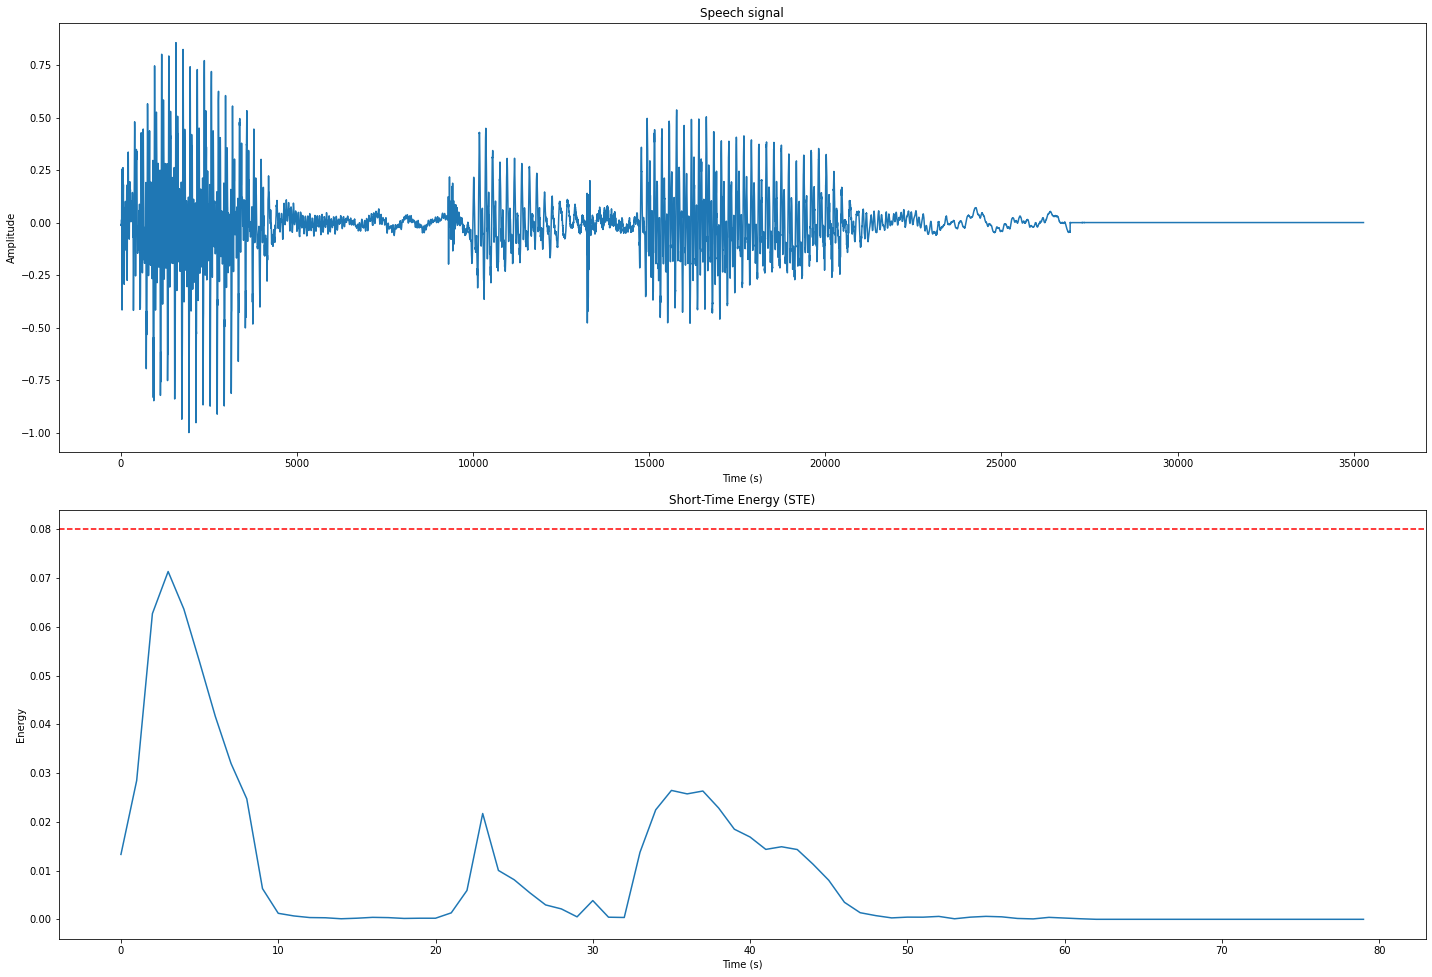

./raw_data/test\wake_words_noise\1_act2 noise WN SNR0 0-4000 time 8 pos 148.wav
[0, 0, 1, 1, 2, 2, 2, 2]
['no', 'no', 'no', 'no', '100', '100 & 110', '300', '148', '100 & 200', '250'] Possibility of attack
44100 [-0.01337344 -0.01129107 -0.00953262 ...  0.00023137 -0.0001851
  0.0001851 ]


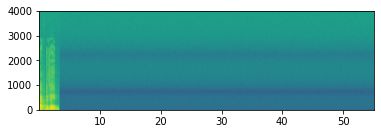

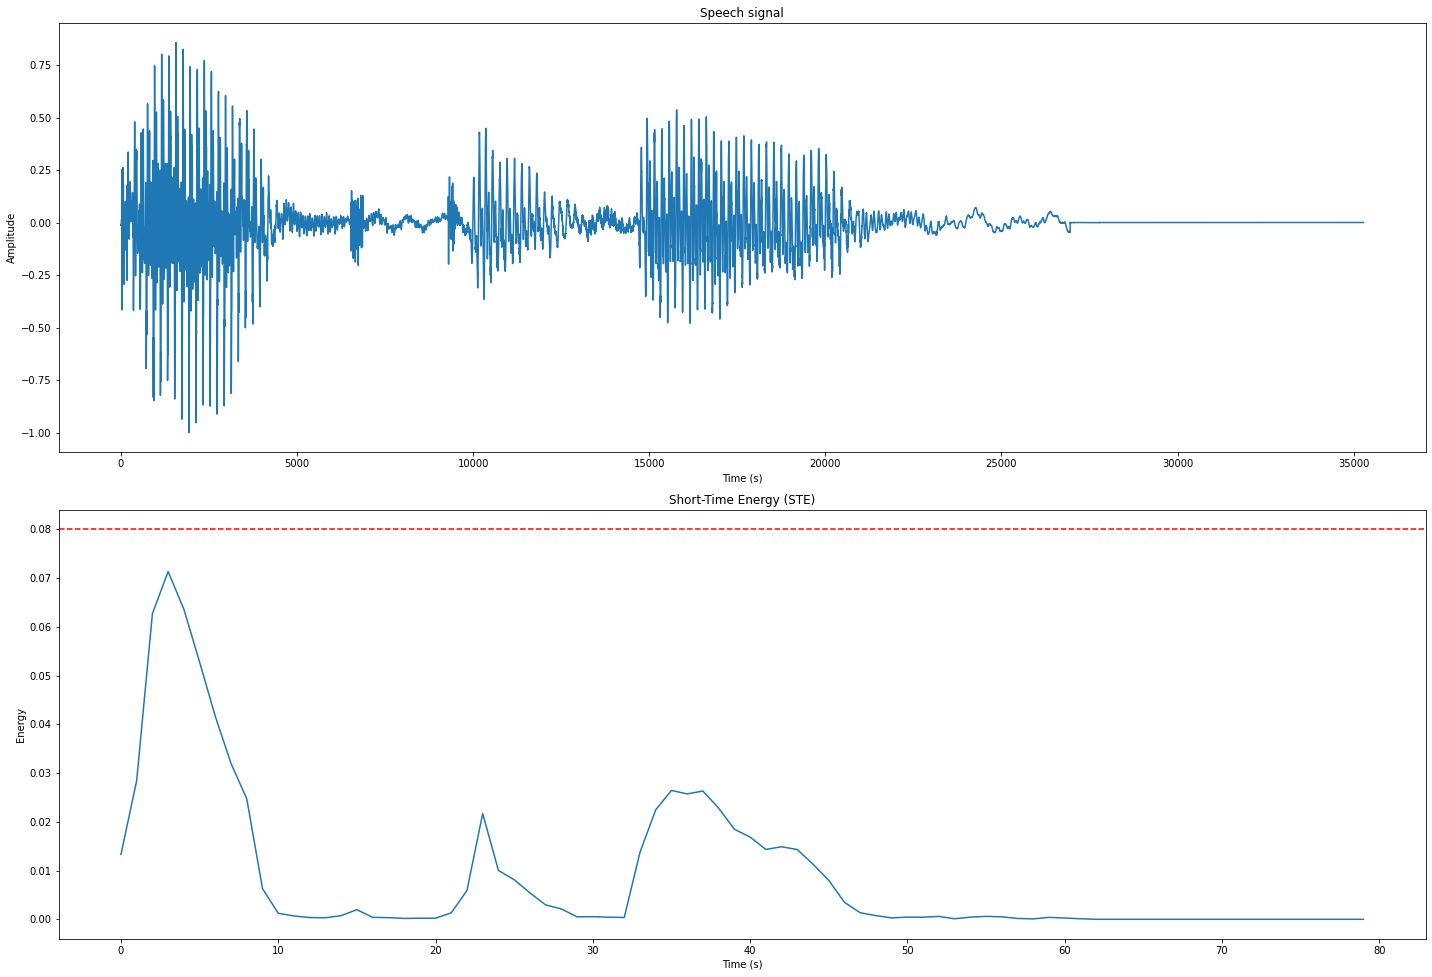

./raw_data/test\wake_words_noise\1_act2 noise11 PN SNR0 BW 0-4000 time 16 pos 100.wav
[0, 0, 1, 1, 2, 2, 2, 2, 0]
./raw_data/test\wake_words_noise\1_act3 noise PN SNR0 BW 0-4000 time 64 pos 250.wav


C:\Users\Prathyusha\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[0, 0, 1, 1, 2, 2, 2, 2, 0, 1]
 True Label  Predicted Label                                                File Name Noise Presence
          0                0                                                    1.wav             no
          0                0                                                    4.wav             no
          1                1                                                   22.wav             no
          1                1                                             activate.wav             no
          2                2  0 noise BN SNR0 BW 0-1000 window length 128 pos 100.wav            100
          2                2   1 noise PN SNR0 BW 0-1000 time 128 pos 100 and 110.wav      100 & 110
          2                2        1_act2 noise PN SNR0 BW 0-4000 time 2 pos 300.wav            300
          2                2           1_act2 noise WN SNR0 0-4000 time 8 pos 148.wav            148
          2                0     1_act2 noise11 PN SNR0 BW 0

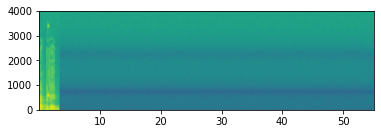

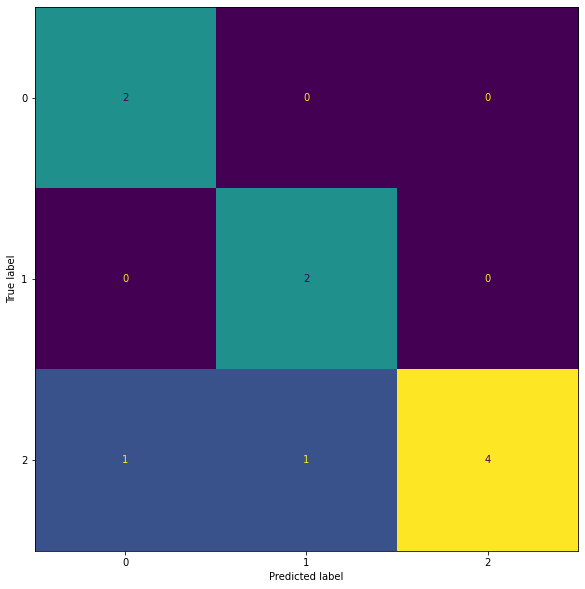

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Replace this with your model's prediction function
end=800
def load_data(path):
    data = []
    for folder in ["non_wake_words", "wake_words", "wake_words_noise"]:
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                data.append((folder, file_path))
    return data

# Label the data
def label_data(data):
    labels = []
    for folder, _ in data:
        if folder == "non_wake_words":
            labels.append(0)
        elif folder == "wake_words":
            labels.append(1)
        elif folder == "wake_words_noise":
            labels.append(2)
    return labels

# Load your data
data_path = "./raw_data/test"
test_data = load_data(data_path)
y_test = label_data(test_data)



#         print(np.amax(predictions1))
    
#         predicted_classes = np.argmax(predictions1, axis=-1)
#         class_values_list = predicted_classes.tolist()[0]

y_pred = []
pos=["no","no","no","no","100","100 & 110","300","148","100 & 200","250"]
for _, file_path in test_data:
    print(file_path)
    predicts = detect_triggerword(file_path)
    pred_classes=np.argmax(predicts,axis=-1)
    pred_label = np.argmax(predicts,axis=-1)[0]  # Extract scalar value from NumPy array
    y_pred.append(max(pred_label))
    print(y_pred)
    class_values_list = pred_classes.tolist()[0]
    if (max(class_values_list)>1):
        file_name, file_extension = os.path.splitext(file_path)
        if file_extension == '.wav':
            wa = AudioSegment.from_wav(file_path)
            wa_1=wa[:end]
            wa_2=wa_1.export("./raw_data/test/cutsound.wav",format="wav")
            print(pos,colored("Possibility of attack","red",attrs=["bold"]))
            fs,s = wav.read("./raw_data/test/cutsound.wav")
            s=s/max(abs(s))
            print(fs,s)
            win = 0.02  # Window size (in seconds)
            hop = 0.01  # Hop size (in seconds)
            threshold = 0.08  # Energy threshold for detecting changes

            # Calculate Short-Time Energy (STE)
            winlen = math.ceil(win * fs)
            hlen = math.ceil(hop * fs)
            slices=math.floor(len(s)/hlen)
            a=np.reshape(s[:hlen *slices], (slices,hlen))
            ste = np.sum( np.transpose(a)** 2, axis=0) / winlen

            # change_points = np.where(np.diff(ste > threshold) != 0)[0]
            # change_points = change_points * hop
            plt.figure(figsize=(20,20))
            plt.subplot(3, 1, 1)
            plt.plot(s)
            plt.title('Speech signal')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')

            plt.subplot(3, 1, 2)
            plt.plot(ste)
            plt.title('Short-Time Energy (STE)')
            plt.xlabel('Time (s)')
            plt.ylabel('Energy')
            plt.axhline(y=threshold, color='r', linestyle='--')
            plt.tight_layout()
            plt.show()
results = {'True Label': y_test,
           'Predicted Label': y_pred,
           'File Name': [os.path.basename(file_path) for _, file_path in test_data],
           'Noise Presence': pos}
df = pd.DataFrame(results)
pd.set_option('display.width', 1000)

print(df.to_string(index=False))
    
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(include_values=True, cmap='viridis', xticks_rotation='horizontal',colorbar=False,ax=ax)
plt.show()
            
        
            
